# Testing detectibility of Hg in 2dF-HERMES spectra of GALAH

In [60]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import convolve
from scipy.io import readsav

In [61]:
def integrate_flux(mu, inten, deltav, vsini, vrt, osamp=1):
    """
    Produces a flux profile by integrating intensity profiles (sampled
    at various mu angles) over the visible stellar surface.
    Intensity profiles are weighted by the fraction of the projected
    stellar surface they represent, apportioning the area between
    adjacent MU points equally. Additional weights (such as those
    used in a Gauss-Legendre quadrature) can not meaningfully be
    used in this scheme.  About twice as many points are required
    with this scheme to achieve the precision of Gauss-Legendre
    quadrature.
    DELTAV, VSINI, and VRT must all be in the same units (e.g. km/s).
    If specified, OSAMP should be a positive integer.
    Parameters
    ----------
    mu : array(float) of size (nmu,)
        cosine of the angle between the outward normal and
        the line of sight for each intensity spectrum in INTEN.
    inten : array(float) of size(nmu, npts)
        intensity spectra at specified values of MU.
    deltav : float
        velocity spacing between adjacent spectrum points
        in INTEN (same units as VSINI and VRT).
    vsini : float
        maximum radial velocity, due to solid-body rotation.
    vrt : float
        radial-tangential macroturbulence parameter, i.e.
        np.sqrt(2) times the standard deviation of a Gaussian distribution
        of turbulent velocities. The same distribution function describes
        the radial motions of one component and the tangential motions of
        a second component. Each component covers half the stellar surface.
        See 'The Observation and Analysis of Stellar Photospheres', Gray.
    osamp : int, optional
        internal oversampling factor for convolutions.
        By default convolutions are done using the input points (OSAMP=1),
        but when OSAMP is set to higher integer values, the input spectra
        are first oversampled by cubic spline interpolation.
    Returns
    -------
    value : array(float) of size (npts,)
        Disk integrated flux profile.
    Note
    ------------
        If you use this algorithm in work that you publish, please cite
        Valenti & Anderson 1996, PASP, currently in preparation.
    """
    """
    History
    -----------
    Feb-88  GM
        Created ANA version.
    13-Oct-92 JAV
        Adapted from G. Marcy's ANA routi!= of the same name.
    03-Nov-93 JAV
        Switched to annular convolution technique.
    12-Nov-93 JAV
        Fixed bug. Intensity compo!=nts not added when vsini=0.
    14-Jun-94 JAV
        Reformatted for "public" release. Heavily commented.
        Pass deltav instead of 2.998d5/deltav. Added osamp
        keyword. Added rebinning logic at end of routine.
        Changed default osamp from 3 to 1.
    20-Feb-95 JAV
        Added mu as an argument to handle arbitrary mu sampling
        and remove ambiguity in intensity profile ordering.
        Interpret VTURB as np.sqrt(2)*sigma instead of just sigma.
        Replaced call_external with call to spl_{init|interp}.
    03-Apr-95 JAV
        Multiply flux by pi to give observed flux.
    24-Oct-95 JAV
        Force "nmk" padding to be at least 3 pixels.
    18-Dec-95 JAV
        Renamed from dskint() to rtint(). No longer make local
        copy of intensities. Use radial-tangential instead
        of isotropic Gaussian macroturbulence.
    26-Jan-99 JAV
        For NMU=1 and VSINI=0, assume resolved solar surface#
        apply R-T macro, but supress vsini broadening.
    01-Apr-99 GMH
        Use annuli weights, rather than assuming ==ual area.
    07-Mar-12 JAV
        Force vsini and vmac to be scalars.
    """

    # Make local copies of various input variables, which will be altered below.
    # Force vsini and especially vmac to be scalars. Otherwise mu dependence fails.

    if np.size(vsini) > 1:
        vsini = vsini[0]
    if np.size(vrt) > 1:
        vrt = vrt[0]

    # Determine oversampling factor.
    os = round(np.clip(osamp, 1, None))  # force integral value > 1

    # Convert input MU to projected radii, R, of annuli for a star of unit radius
    #  (which is just sine, rather than cosine, of the angle between the outward
    #  normal and the line of sight).
    rmu = np.sqrt(1 - mu ** 2)  # use simple trig identity

    # Sort the projected radii and corresponding intensity spectra into ascending
    #  order (i.e. from disk center to the limb), which is equivalent to sorting
    #  MU in descending order.
    isort = np.argsort(rmu)
    rmu = rmu[isort]  # reorder projected radii
    nmu = np.size(mu)  # number of radii
    if nmu == 1:
        if vsini != 0:
            logger.warning(
                "Vsini is non-zero, but only one projected radius (mu value) is set. No rotational broadening will be performed."
            )
            vsini = 0  # ignore vsini if only 1 mu

    # Calculate projected radii for boundaries of disk integration annuli.  The n+1
    # boundaries are selected such that r(i+1) exactly bisects the area between
    # rmu(i) and rmu(i+1). The in!=rmost boundary, r(0) is set to 0 (disk center)
    # and the outermost boundary, r(nmu) is set to 1 (limb).
    if nmu > 1 or vsini != 0:  # really want disk integration
        r = np.sqrt(
            0.5 * (rmu[:-1] ** 2 + rmu[1:] ** 2)
        )  # area midpoints between rmu
        r = np.concatenate(([0], r, [1]))

        # Calculate integration weights for each disk integration annulus.  The weight
        # is just given by the relative area of each annulus, normalized such that
        # the sum of all weights is unity.  Weights for limb darkening are included
        # explicitly in the intensity profiles, so they aren't needed here.
        wt = r[1:] ** 2 - r[:-1] ** 2  # weights = relative areas
    else:
        wt = np.array([1.0])  # single mu value, full weight

    # Generate index vectors for input and oversampled points. Note that the
    # oversampled indicies are carefully chosen such that every "os" finely
    # sampled points fit exactly into one input bin. This makes it simple to
    # "integrate" the finely sampled points at the end of the routine.
    npts = inten.shape[1]  # number of points
    xpix = np.arange(npts, dtype=float)  # point indices
    nfine = os * npts  # number of oversampled points
    xfine = (0.5 / os) * (
        2 * np.arange(nfine, dtype=float) - os + 1
    )  # oversampled points indices

    # Loop through annuli, constructing and convolving with rotation kernels.

    yfine = np.empty(nfine)  # init oversampled intensities
    flux = np.zeros(nfine)  # init flux vector
    for imu in range(nmu):  # loop thru integration annuli

        #  Use external cubic spline routine (adapted from Numerical Recipes) to make
        #  an oversampled version of the intensity profile for the current annulus.
        ypix = inten[isort[imu]]  # extract intensity profile
        if os == 1:
            # just copy (use) original profile
            yfine = ypix
        else:
            # spline onto fine wavelength scale
            yfine = interp1d(xpix, ypix, kind="cubic")(xfine)

        # Construct the convolution kernel which describes the distribution of
        # rotational velocities present in the current annulus. The distribution has
        # been derived analytically for annuli of arbitrary thickness in a rigidly
        # rotating star. The kernel is constructed in two pieces: o!= piece for
        # radial velocities less than the maximum velocity along the inner edge of
        # the annulus, and one piece for velocities greater than this limit.
        if vsini > 0:
            # nontrivial case
            r1 = r[imu]  # inner edge of annulus
            r2 = r[imu + 1]  # outer edge of annulus
            dv = deltav / os  # oversampled velocity spacing
            maxv = vsini * r2  # maximum velocity in annulus
            nrk = 2 * int(maxv / dv) + 3  ## oversampled kernel point
            # velocity scale for kernel
            v = dv * (np.arange(nrk, dtype=float) - ((nrk - 1) / 2))
            rkern = np.zeros(nrk)  # init rotational kernel
            j1 = np.abs(v) < vsini * r1  # low velocity points
            rkern[j1] = np.sqrt((vsini * r2) ** 2 - v[j1] ** 2) - np.sqrt(
                (vsini * r1) ** 2 - v[j1] ** 2
            )  # generate distribution

            j2 = (np.abs(v) >= vsini * r1) & (np.abs(v) <= vsini * r2)
            rkern[j2] = np.sqrt(
                (vsini * r2) ** 2 - v[j2] ** 2
            )  # generate distribution

            rkern = rkern / np.sum(rkern)  # normalize kernel

            # Convolve the intensity profile with the rotational velocity kernel for this
            # annulus. Pad each end of the profile with as many points as are in the
            # convolution kernel. This reduces Fourier ringing. The convolution may also
            # be do!= with a routi!= called "externally" from IDL, which efficiently
            # shifts and adds.
            if nrk > 3:
                yfine = convolve(yfine, rkern, mode="nearest")

        # Calculate projected sigma for radial and tangential velocity distributions.
        muval = mu[isort[imu]]  # current value of mu
        sigma = os * vrt / np.sqrt(2) / deltav  # standard deviation in points
        sigr = sigma * muval  # reduce by current mu value
        sigt = sigma * np.sqrt(1.0 - muval ** 2)  # reduce by np.sqrt(1-mu**2)

        # Figure out how many points to use in macroturbulence kernel.
        nmk = int(10 * sigma)
        nmk = np.clip(nmk, 3, (nfine - 3) // 2)

        # Construct radial macroturbulence kernel with a sigma of mu*VRT/np.sqrt(2).
        if sigr > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigr
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mrkern = np.exp(xarg)  # compute the gaussian
            mrkern = mrkern / np.sum(mrkern)  # normalize the profile
        else:
            mrkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mrkern[nmk] = 1.0  # delta function

        # Construct tangential kernel with a sigma of np.sqrt(1-mu**2)*VRT/np.sqrt(2).
        if sigt > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigt
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mtkern = np.exp(xarg)  # compute the gaussian
            mtkern = mtkern / np.sum(mtkern)  # normalize the profile
        else:
            mtkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mtkern[nmk] = 1.0  # delta function

        # Sum the radial and tangential components, weighted by surface area.
        area_r = 0.5  # assume equal areas
        area_t = 0.5  # ar+at must equal 1
        mkern = area_r * mrkern + area_t * mtkern  # add both components

        # Convolve the total flux profiles, again padding the spectrum on both ends to
        # protect against Fourier ringing.
        yfine = convolve(
            yfine, mkern, mode="nearest"
        )  # add the padding and convolve

        # Add contribution from current annulus to the running total.
        flux = flux + wt[imu] * yfine  # add profile to running total

    flux = np.reshape(flux, (npts, os))  # convert to an array
    flux = np.pi * np.sum(flux, axis=1) / os  # sum, normalize
    return flux

In [62]:
def broaden_spectrum(wint_seg, sint_seg, wave_seg, cmod_seg, vsini=0, vmac=0, debug=False):

    nw = len(wint_seg)
    clight = 299792.5
    mu = (np.sqrt(0.5*(2*np.arange(7)+1)/np.float(7)))[::-1]
    nmu = 7
    wmid = 0.5 * (wint_seg[nw-1] + wint_seg[0])
    wspan = wint_seg[nw-1] - wint_seg[0]
    jmin = np.argmin(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep1 = min(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep2 = 0.1 * wspan / (nw-1) / wmid * clight
    vstep3 = 0.05
    vstep = np.max([vstep1,vstep2,vstep3])

    # Generate model wavelength scale X, with uniform wavelength step.
    nx = int(np.floor(np.log10(wint_seg[nw-1] / wint_seg[0])/ np.log10(1.0+vstep / clight))+1)
    if nx % 2 == 0: nx += 1
    resol_out = 1.0/((wint_seg[nw-1] / wint_seg[0])**(1.0/(nx-1.0))-1.0)
    vstep = clight / resol_out
    x_seg = wint_seg[0] * (1.0 + 1.0 / resol_out)**np.arange(nx)

    # Interpolate intensity spectra onto new model wavelength scale.  
    yi_seg = np.empty((nmu, nx))

    for imu in range(nmu):
        yi_seg[imu] = np.interp(x_seg, wint_seg, sint_seg[imu])

    y_seg = integrate_flux(mu, yi_seg, vstep, np.abs(vsini), np.abs(vmac))

    dispersion = vstep1
    wave_equi = np.arange(x_seg[0],x_seg[-1]+dispersion,dispersion)

    c_seg = np.interp(wave_equi,wave_seg,cmod_seg)
    y_seg = np.interp(wave_equi,x_seg,y_seg)

    if debug:
        print(vstep1,len(wave_equi))

    return(wave_equi,y_seg/c_seg)

In [63]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [64]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    """
    Apply Gaussian Instrument Broadening
    
    INPUT:
    wave : wavelength array 
    smod : modelled signal
    ipres : instrumental profile resolution
    
    OUTPUT:
    broadened modelled signal
    """
    
    # 
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

## Preparing input for spectrum synthesis

Here, we are reading in the default results of the GALAH DR4 analysis.  

Note: These spectra are not directly synthesised by our code (Spectroscopy Made Easy == SME), but interpolated by a neural network.

I have therefore taken the liberty to recompute an SME synthetic spectrum and change [Hg/Fe] to either +0.0 (index 0) dex or +1.0 dex (index 1)

In [65]:
# Read in the GALAH DR4 raw result
galah_dr4_raw_result = Table.read('/avatar/buder/GALAH_DR4/analysis_products/171227/171227004801060/171227004801060_plxcom_fit_results.fits')

In [66]:
def convert_solar_abundances_to_sme_compatible_format(abundance_dictionary):
    """
    This function converts the relative abundance, [X/Fe], in an abundance dictionary
    to the SME-compatible format *sme_abund*.
    
    The solar abundance pattern of SME (as well as the MARCS 2012) grid
    is from Grevesse et al. (2007, http://adsabs.harvard.edu/abs/2007SSRv..130..105G)

    Input:
    abundance_dictionary : dictionary where each element has its [X/Fe] value saved under 'x_fe'
    
    Output:
    np.array(99,1) with all elements needed for the SME *sme.abund* input field

    """
    
    # Grevesse et al. (2007) abundance pattern
    #       "H",  "He",  "Li",  "Be",   "B",   "C",   "N",   "O",   "F",  "Ne",
    a_x= [12.00, 10.93,  1.05,  1.38,  2.70,  8.39,  7.78,  8.66,  4.56,  7.84,
    #      "Na",  "Mg",  "Al",  "Si",   "P",   "S",  "Cl",  "Ar",   "K",  "Ca",
           6.17,  7.53,  6.37,  7.51,  5.36,  7.14,  5.50,  6.18,  5.08,  6.31,
    #      "Sc",  "Ti",   "V",  "Cr",  "Mn",  "Fe",  "Co",  "Ni",  "Cu",  "Zn",
           3.17,  4.90,  4.00,  5.64,  5.39,  7.45,  4.92,  6.23,  4.21,  4.60,
    #      "Ga",  "Ge",  "As",  "Se",  "Br",  "Kr",  "Rb",  "Sr",   "Y",  "Zr",
           2.88,  3.58,  2.29,  3.33,  2.56,  3.25,  2.60,  2.92,  2.21,  2.58,
    #      "Nb",  "Mo",  "Tc",  "Ru",  "Rh",  "Pd",  "Ag",  "Cd",  "In",  "Sn",
           1.42,  1.92, -8.00,  1.84,  1.12,  1.66,  0.94,  1.77,  1.60,  2.00,
    #      "Sb",  "Te",   "I",  "Xe",  "Cs",  "Ba",  "La",  "Ce",  "Pr",  "Nd",
           1.00,  2.19,  1.51,  2.24,  1.07,  2.17,  1.13,  1.70,  0.58,  1.45,
    #      "Pm",  "Sm",  "Eu",  "Gd",  "Tb",  "Dy",  "Ho",  "Er",  "Tm",  "Yb",
          -8.00,  1.00,  0.52,  1.11,  0.28,  1.14,  0.51,  0.93,  0.00,  1.08,
    #      "Lu",  "Hf",  "Ta",   "W",  "Re",  "Os",  "Ir",  "Pt",  "Au",  "Hg",
           0.06,  0.88, -0.17,  1.11,  0.23,  1.25,  1.38,  1.64,  1.01,  1.13,
    #      "Tl",  "Pb",  "Bi",  "Po",  "At",  "Rn",  "Fr",  "Ra",  "Ac",  "Th",
           0.90,  2.00,  0.65, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00,  0.06,
    #      "Pa",   "U",  "Np",  "Pu",  "Am",  "Cm",  "Bk",  "Cs",  "Es", "TiO" 
          -8.00, -0.52, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00]
    log_eonh = np.array(a_x) - 12.0
    
    # Loop over all elements that 
    elements = np.array(['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu','Hg'])
    element_indices = np.array([3,6,7,8,11,12,13,14,19,20,21,22,23,24,25,27,28,29,30,37,38,39,40,42,44,56,57,58,60,62,63,80])-1
    for index, element in enumerate(elements):
        element_index = element_indices[index]
        if element.lower()+'_fe' in abundance_dictionary.keys():
            log_eonh[element_index] += abundance_dictionary[element.lower()+'_fe']
        else:
            print('Warning: '+element+' / '+element.lower()+'_fe'+' not in input dictionary')
    
    # SME expects a normalised input format. Here we do the necessary renormalisation
    eonh = 10**log_eonh
    renorm = np.sum(eonh)
    eontot = eonh / renorm
    log_eontot = np.log10(eontot).astype(float)
    abund = log_eontot
    abund[0] = eonh[0] / renorm
    abund = abund.astype(float)
    
    return(abund)

In [86]:
# Create the 2 spectra with solar and increased [Hg/Fe]

hg_test_calculuations = Table()

# unique identifier
hg_test_calculuations['spectrum_index'] = np.arange(8)

teffs = [
    galah_dr4_raw_result['teff'][0],
    galah_dr4_raw_result['teff'][0],
    5000.,
    5000.,
    5772.,
    5772.,
    7750,
    7750
]

loggs = [
    galah_dr4_raw_result['logg'][0],
    galah_dr4_raw_result['logg'][0],
    4.0,
    4.0,
    4.44,
    4.44,
    4.0,
    4.0
]

fehs = [
    galah_dr4_raw_result['fe_h'][0],
    galah_dr4_raw_result['fe_h'][0],
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
]

def vmic_DF16(teff, logg):
    """
    https://ui.adsabs.harvard.edu/abs/2016A%26A...585A..75D/abstract
    """
    return 0.998+3.16*10**(-4)*(teff-5500.)-0.253*(logg-4.0)-2.86*10**(-4)*(teff-5500)*(logg-4.0)+0.165*(logg-4.0)**2.

vmics = [
    galah_dr4_raw_result['vmic'][0],
    galah_dr4_raw_result['vmic'][0],
    vmic_DF16(5500.,4.0),
    vmic_DF16(5500.,4.0),
    vmic_DF16(5772.,4.44),
    vmic_DF16(5772.,4.44),
    vmic_DF16(7750.,4.0),
    vmic_DF16(7750.,4.0)
]

# main labels stay the same
hg_test_calculuations['teff'] = np.array(teffs)
hg_test_calculuations['logg'] = np.array(loggs)
hg_test_calculuations['fe_h'] = np.array(fehs)
hg_test_calculuations['vmic'] = np.array(vmics)

# adjust the abundance table

# 0) with [Hg/Fe] = 0
abundances_0 = galah_dr4_raw_result
abundances_0['hg_fe'] = 0.0
sme_abundances_0 = convert_solar_abundances_to_sme_compatible_format(abundances_0)

# 1) with [Hg/Fe] = 0
abundances_1 = galah_dr4_raw_result
abundances_1['hg_fe'] = 1.0
sme_abundances_1 = convert_solar_abundances_to_sme_compatible_format(abundances_1)

solar = dict()
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu','Hg']:
    solar[element.lower()+'_fe'] = 0.0

sme_abundances_2 = convert_solar_abundances_to_sme_compatible_format(solar)

solar_hgfe_1 = solar
solar_hgfe_1['hg_fe'] = 1.0

sme_abundances_3 = convert_solar_abundances_to_sme_compatible_format(solar_hgfe_1)

hg_test_calculuations['sme_abund'] = np.array([sme_abundances_0,sme_abundances_1,sme_abundances_2,sme_abundances_3,sme_abundances_2,sme_abundances_3,sme_abundances_2,sme_abundances_3])

hg_test_calculuations.write('data/hg_computation.fits',overwrite=True)

hg_test_calculuations

spectrum_index,teff,logg,fe_h,vmic,sme_abund [99]
int64,float64,float64,float64,float64,float64
0,4249.7900390625,1.7036707170146,-0.3633255660533905,1.4754085540771484,0.916243831890304 .. -20.037988935990676
1,4249.7900390625,1.7036707170146,-0.3633255660533905,1.4754085540771484,0.9162438317883828 .. -20.037988936038985
2,5000.0,4.0,0.0,0.998,0.9207554264109681 .. -20.035855712979814
3,5000.0,4.0,0.0,0.998,0.9207554263080407 .. -20.03585571302836
4,5772.0,4.44,0.0,0.97034752,0.9207554264109681 .. -20.035855712979814
5,5772.0,4.44,0.0,0.97034752,0.9207554263080407 .. -20.03585571302836
6,7750.0,4.0,0.0,1.709,0.9207554264109681 .. -20.035855712979814
7,7750.0,4.0,0.0,1.709,0.9207554263080407 .. -20.03585571302836


## Synthesise synethetic spectra
This step is done in IDL and too long to explain in detail. But briefly: we adjust a template with all lines to one that only includes the necessary lines for the given stellar type and then create a synthetic spectrum with the abundances defined in sme_abund. To save time, the code is written to only compute specific CCDs (2dF-HERMES has 4, with the Hg line in the 2nd).

SME then creates an IDL output format that we can luckily read in with a python scipy package

## Read in synthetic spectra

In [88]:
# SME will provide a high-resolution spectrum for R = 300,000.
high_res_spectrum_high_hgfe_0_ccd2 = readsav('data/high_hgfe_0_ccd2.out').results[0]
high_res_spectrum_high_hgfe_1_ccd2 = readsav('data/high_hgfe_1_ccd2.out').results[0]
high_res_spectrum_high_hgfe_2_ccd2 = readsav('data/high_hgfe_2_ccd2.out').results[0]
high_res_spectrum_high_hgfe_3_ccd2 = readsav('data/high_hgfe_3_ccd2.out').results[0]
high_res_spectrum_high_hgfe_4_ccd2 = readsav('data/high_hgfe_4_ccd2.out').results[0]
high_res_spectrum_high_hgfe_5_ccd2 = readsav('data/high_hgfe_5_ccd2.out').results[0]
high_res_spectrum_high_hgfe_6_ccd2 = readsav('data/high_hgfe_6_ccd2.out').results[0]
high_res_spectrum_high_hgfe_7_ccd2 = readsav('data/high_hgfe_7_ccd2.out').results[0]

# Explanation of keywords:
# WAVE : Wavelength in Ångström
# SMOD : normalised, integrated synthetic flux
# CMOD : integrated continuum flux (you can get the integrated absolute flux via SMOD*CMOD)
# WINT : Wavelength in Ångström for 7 equal area angles of the stellar disk
# SINT : absolute flux in Ångström for 7 equal area angles of the stellar disk

## Plot Highest Resolution (R = 300,000) synthesis of non-rotating case

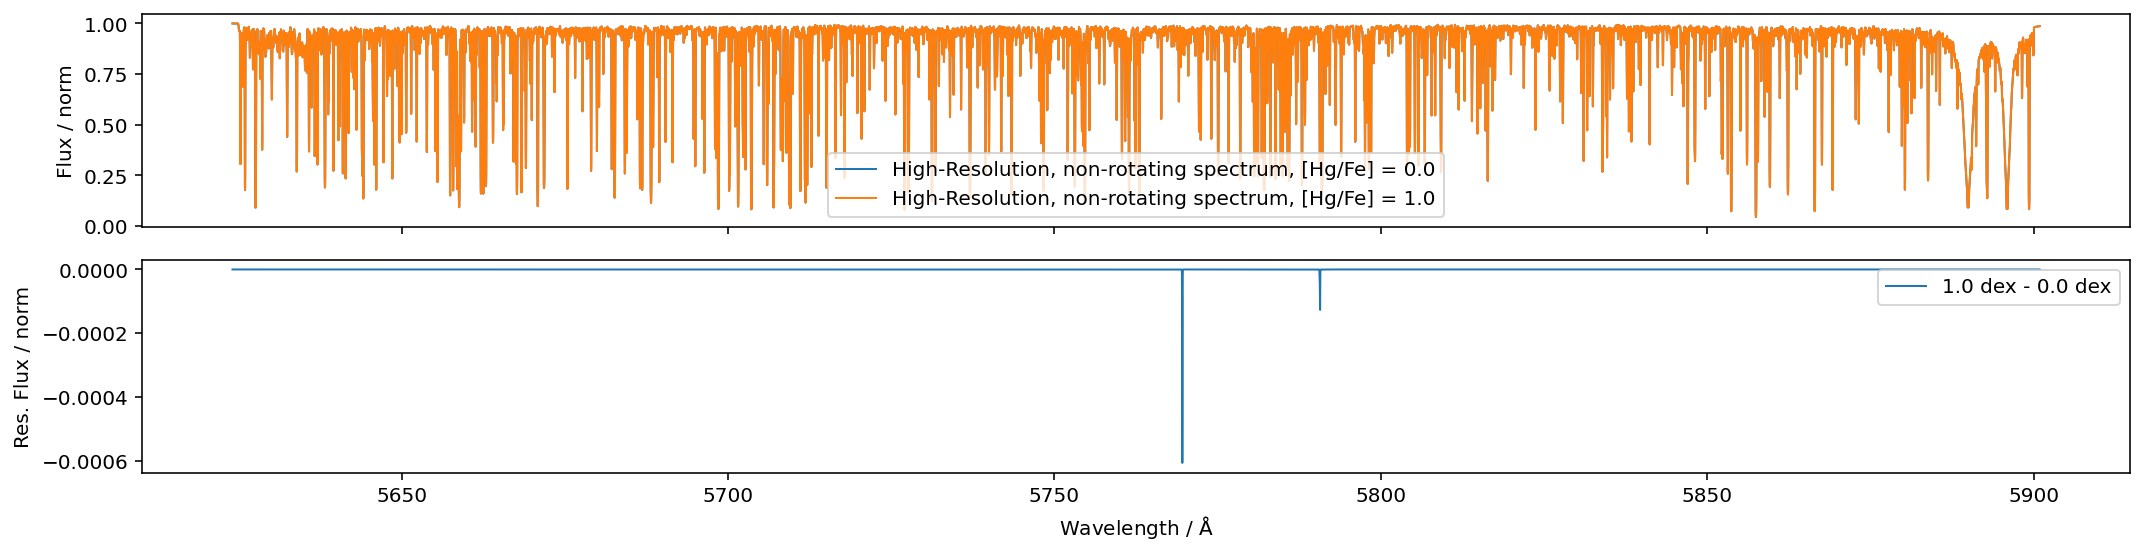

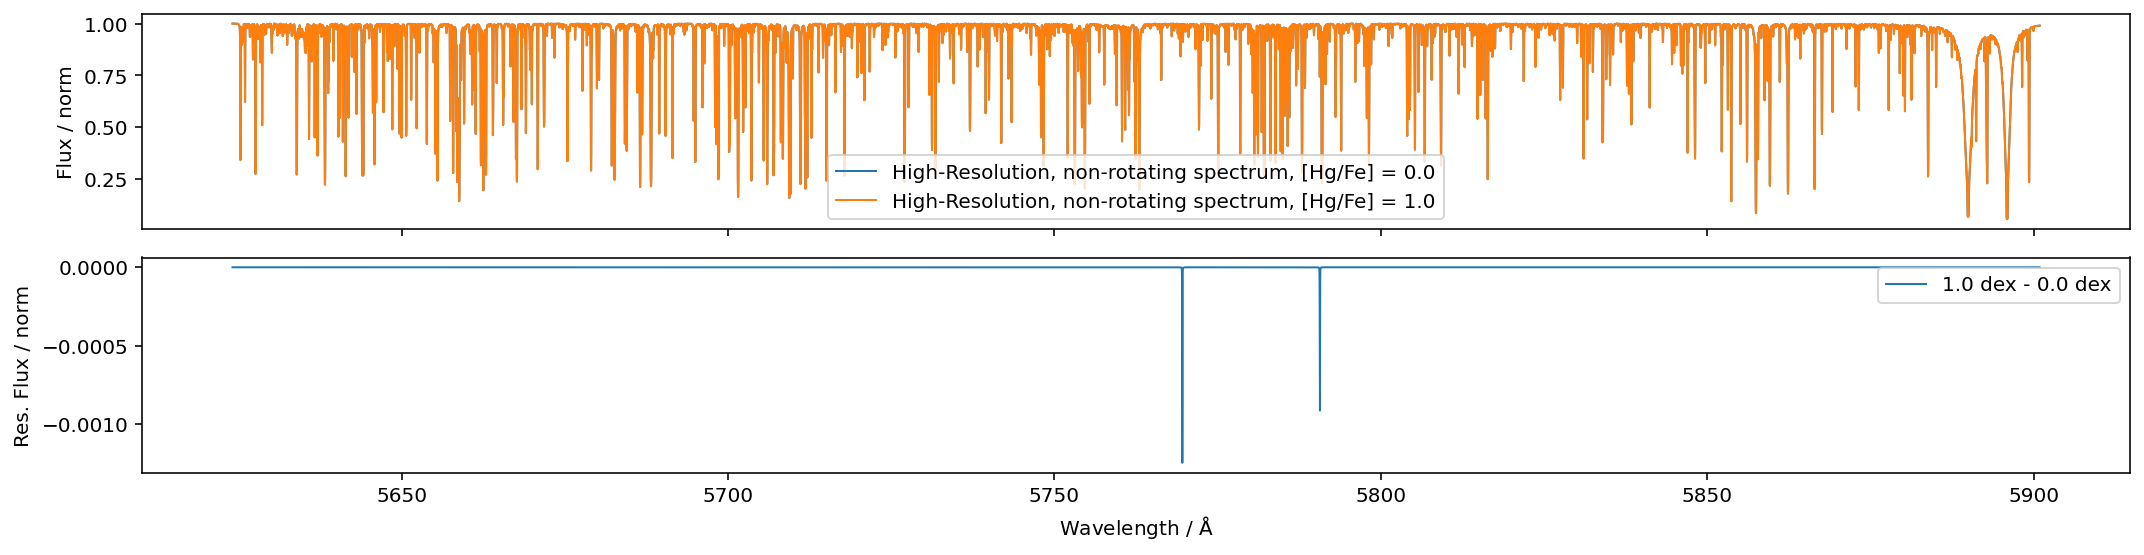

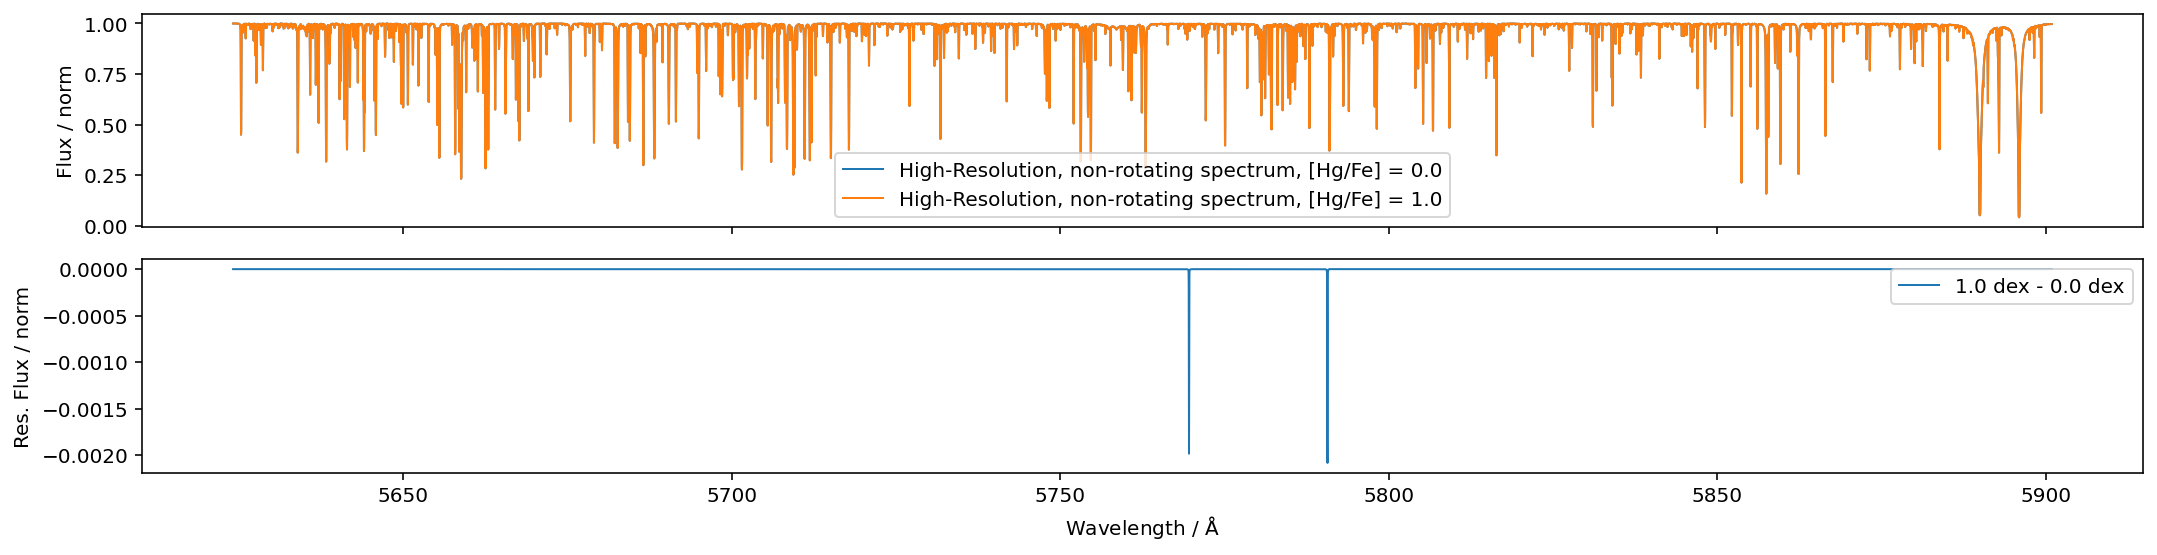

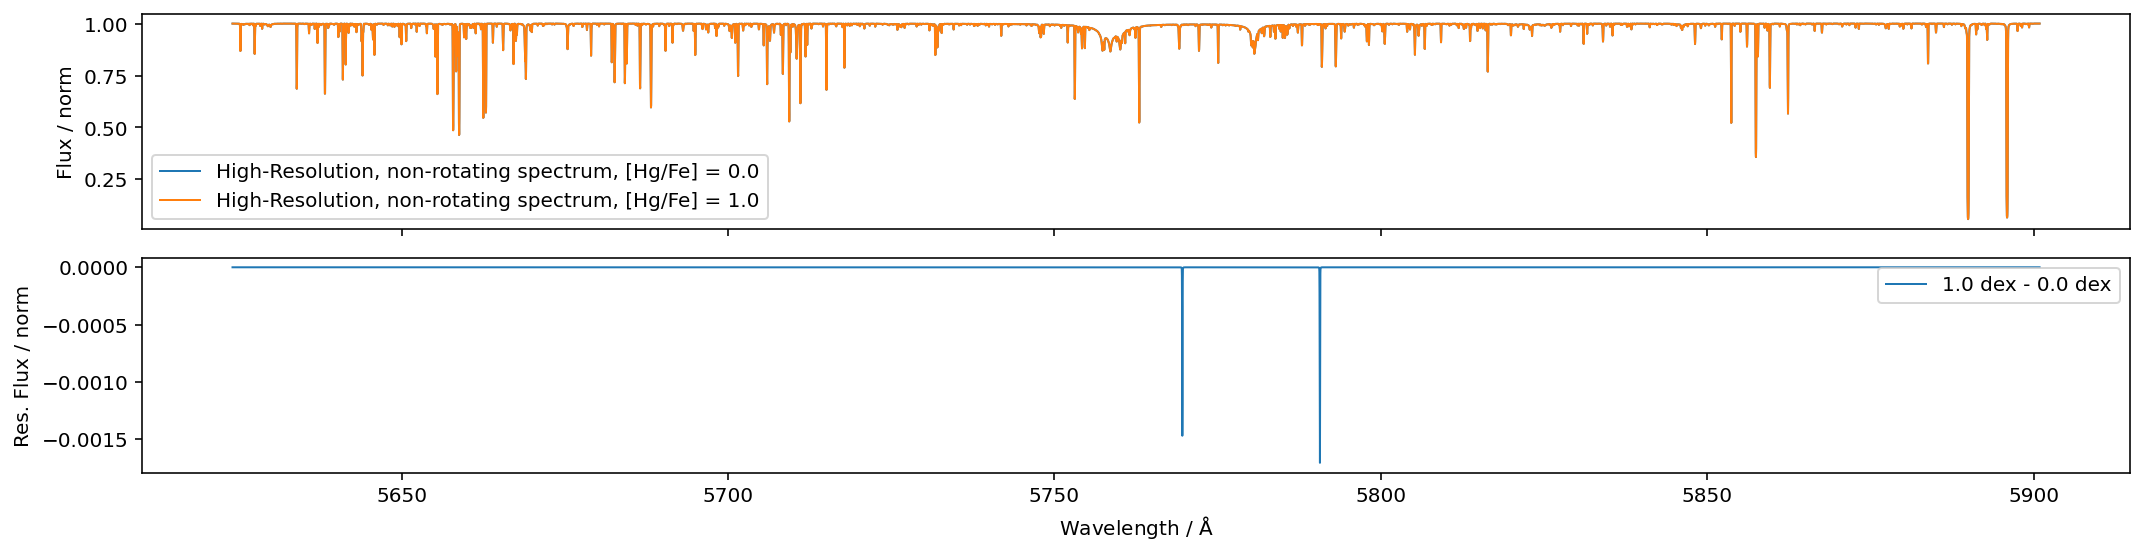

In [89]:
f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    high_res_spectrum_high_hgfe_0_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_0_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    high_res_spectrum_high_hgfe_1_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_1_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    high_res_spectrum_high_hgfe_0_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_1_ccd2['SMOD']-
    high_res_spectrum_high_hgfe_0_ccd2['SMOD'],
    label = r'1.0 dex - 0.0 dex',lw=1
)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

#####

f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    high_res_spectrum_high_hgfe_2_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_2_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    high_res_spectrum_high_hgfe_3_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_3_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    high_res_spectrum_high_hgfe_2_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_3_ccd2['SMOD']-
    high_res_spectrum_high_hgfe_2_ccd2['SMOD'],
    label = r'1.0 dex - 0.0 dex',lw=1
)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

###

f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    high_res_spectrum_high_hgfe_4_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_4_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    high_res_spectrum_high_hgfe_5_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_5_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    high_res_spectrum_high_hgfe_4_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_5_ccd2['SMOD']-
    high_res_spectrum_high_hgfe_4_ccd2['SMOD'],
    label = r'1.0 dex - 0.0 dex',lw=1
)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

###

f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    high_res_spectrum_high_hgfe_6_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_6_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    high_res_spectrum_high_hgfe_7_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_7_ccd2['SMOD'],
    label = 'High-Resolution, non-rotating spectrum, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    high_res_spectrum_high_hgfe_6_ccd2['WAVE'],
    high_res_spectrum_high_hgfe_7_ccd2['SMOD']-
    high_res_spectrum_high_hgfe_6_ccd2['SMOD'],
    label = r'1.0 dex - 0.0 dex',lw=1
)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

## Apply rotational and instrumental broadening to mimic 2dF-HERMES observation

In [90]:
# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_0, smod_broadened_spectrum_hgfe_0 = broaden_spectrum(
    high_res_spectrum_high_hgfe_0_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_0_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_0_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_0_ccd2['CMOD'], 
    vsini=galah_dr4_raw_result['vsini'], 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_0 = wave_broadened_spectrum_hgfe_0
smod_hermes_like_spectrum_hgfe_0 = apply_gauss_broad(wave_broadened_spectrum_hgfe_0, smod_broadened_spectrum_hgfe_0, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_1, smod_broadened_spectrum_hgfe_1 = broaden_spectrum(
    high_res_spectrum_high_hgfe_1_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_1_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_1_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_1_ccd2['CMOD'], 
    vsini=galah_dr4_raw_result['vsini'], 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_1 = wave_broadened_spectrum_hgfe_1
smod_hermes_like_spectrum_hgfe_1 = apply_gauss_broad(wave_broadened_spectrum_hgfe_1, smod_broadened_spectrum_hgfe_1, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_2, smod_broadened_spectrum_hgfe_2 = broaden_spectrum(
    high_res_spectrum_high_hgfe_2_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_2_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_2_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_2_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_2 = wave_broadened_spectrum_hgfe_2
smod_hermes_like_spectrum_hgfe_2 = apply_gauss_broad(wave_broadened_spectrum_hgfe_2, smod_broadened_spectrum_hgfe_2, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_3, smod_broadened_spectrum_hgfe_3 = broaden_spectrum(
    high_res_spectrum_high_hgfe_3_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_3_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_3_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_3_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_3 = wave_broadened_spectrum_hgfe_3
smod_hermes_like_spectrum_hgfe_3 = apply_gauss_broad(wave_broadened_spectrum_hgfe_3, smod_broadened_spectrum_hgfe_3, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_4, smod_broadened_spectrum_hgfe_4 = broaden_spectrum(
    high_res_spectrum_high_hgfe_4_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_4_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_4_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_4_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_4 = wave_broadened_spectrum_hgfe_4
smod_hermes_like_spectrum_hgfe_4 = apply_gauss_broad(wave_broadened_spectrum_hgfe_4, smod_broadened_spectrum_hgfe_4, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_5, smod_broadened_spectrum_hgfe_5 = broaden_spectrum(
    high_res_spectrum_high_hgfe_5_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_5_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_5_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_5_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_5 = wave_broadened_spectrum_hgfe_5
smod_hermes_like_spectrum_hgfe_5 = apply_gauss_broad(wave_broadened_spectrum_hgfe_5, smod_broadened_spectrum_hgfe_5, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_6, smod_broadened_spectrum_hgfe_6 = broaden_spectrum(
    high_res_spectrum_high_hgfe_6_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_6_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_6_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_6_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_6 = wave_broadened_spectrum_hgfe_6
smod_hermes_like_spectrum_hgfe_6 = apply_gauss_broad(wave_broadened_spectrum_hgfe_6, smod_broadened_spectrum_hgfe_6, ipres=28000, debug=True)

# We first integrate the spectrum from the 7 viewing angles while properly taking into account rotation
wave_broadened_spectrum_hgfe_7, smod_broadened_spectrum_hgfe_7 = broaden_spectrum(
    high_res_spectrum_high_hgfe_7_ccd2['WINT'], 
    high_res_spectrum_high_hgfe_7_ccd2['SINT'], 
    high_res_spectrum_high_hgfe_7_ccd2['WAVE'], 
    high_res_spectrum_high_hgfe_7_ccd2['CMOD'], 
    vsini=5.0, 
    vmac=0, 
    debug=False
)

# Then we apply the instrumental broadening by assuming a gaussian shape with certain R value
wave_hermes_like_spectrum_hgfe_7 = wave_broadened_spectrum_hgfe_7
smod_hermes_like_spectrum_hgfe_7 = apply_gauss_broad(wave_broadened_spectrum_hgfe_7, smod_broadened_spectrum_hgfe_7, ipres=28000, debug=True)

## Plot HERMES-like resolution of rotating case

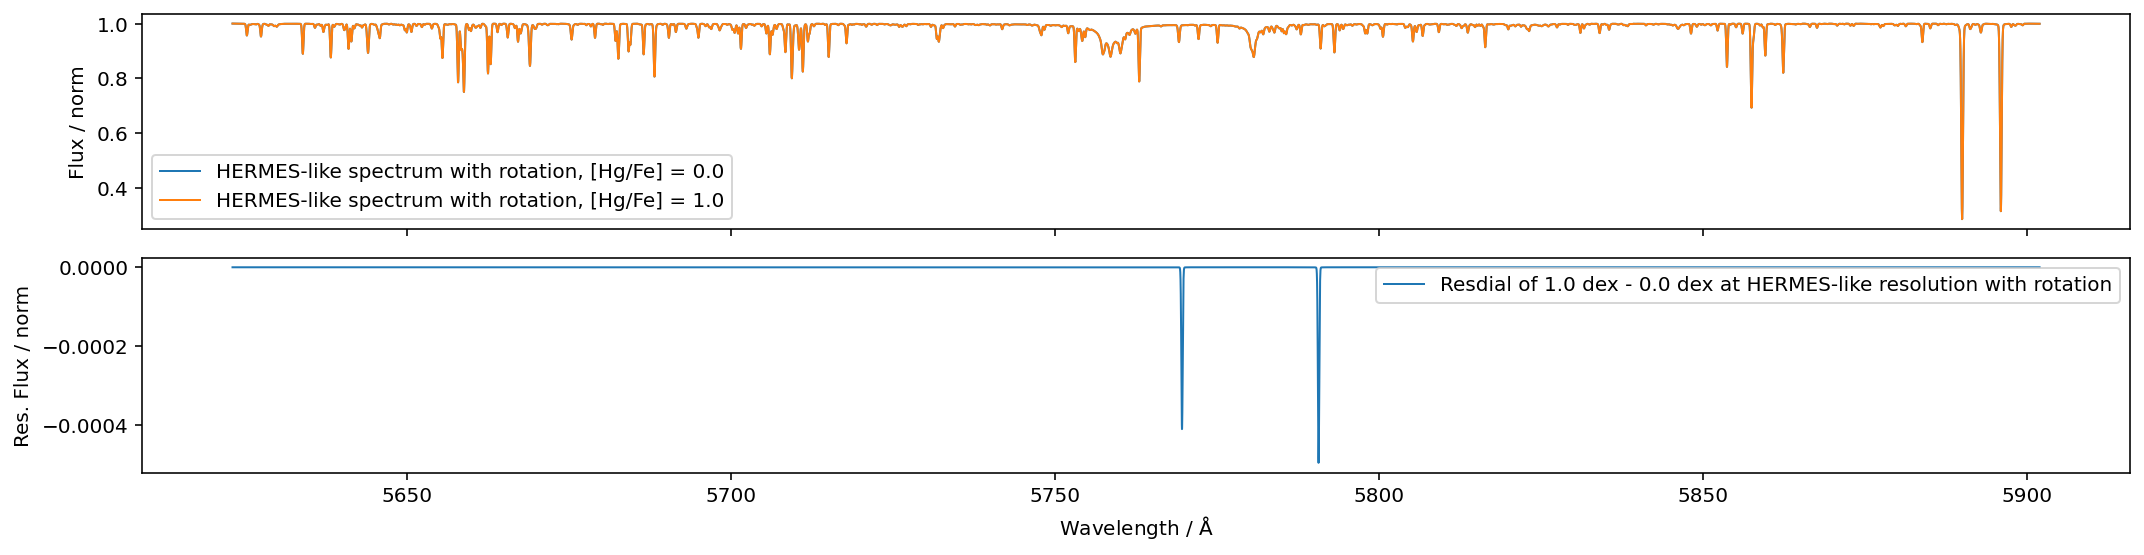

In [97]:
f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    wave_hermes_like_spectrum_hgfe_6,
    smod_hermes_like_spectrum_hgfe_6,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    wave_hermes_like_spectrum_hgfe_7,
    smod_hermes_like_spectrum_hgfe_7,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    wave_hermes_like_spectrum_hgfe_6,
    smod_hermes_like_spectrum_hgfe_7-
    smod_hermes_like_spectrum_hgfe_6,
    label = r'Resdial of 1.0 dex - 0.0 dex at HERMES-like resolution with rotation',lw=1
)
ax.legend()

plt.tight_layout()
plt.savefig('impact_hg_fe_change_of_1dex_for_ftype_ccd2.pdf',dpi=200,bbox_inches='tight')

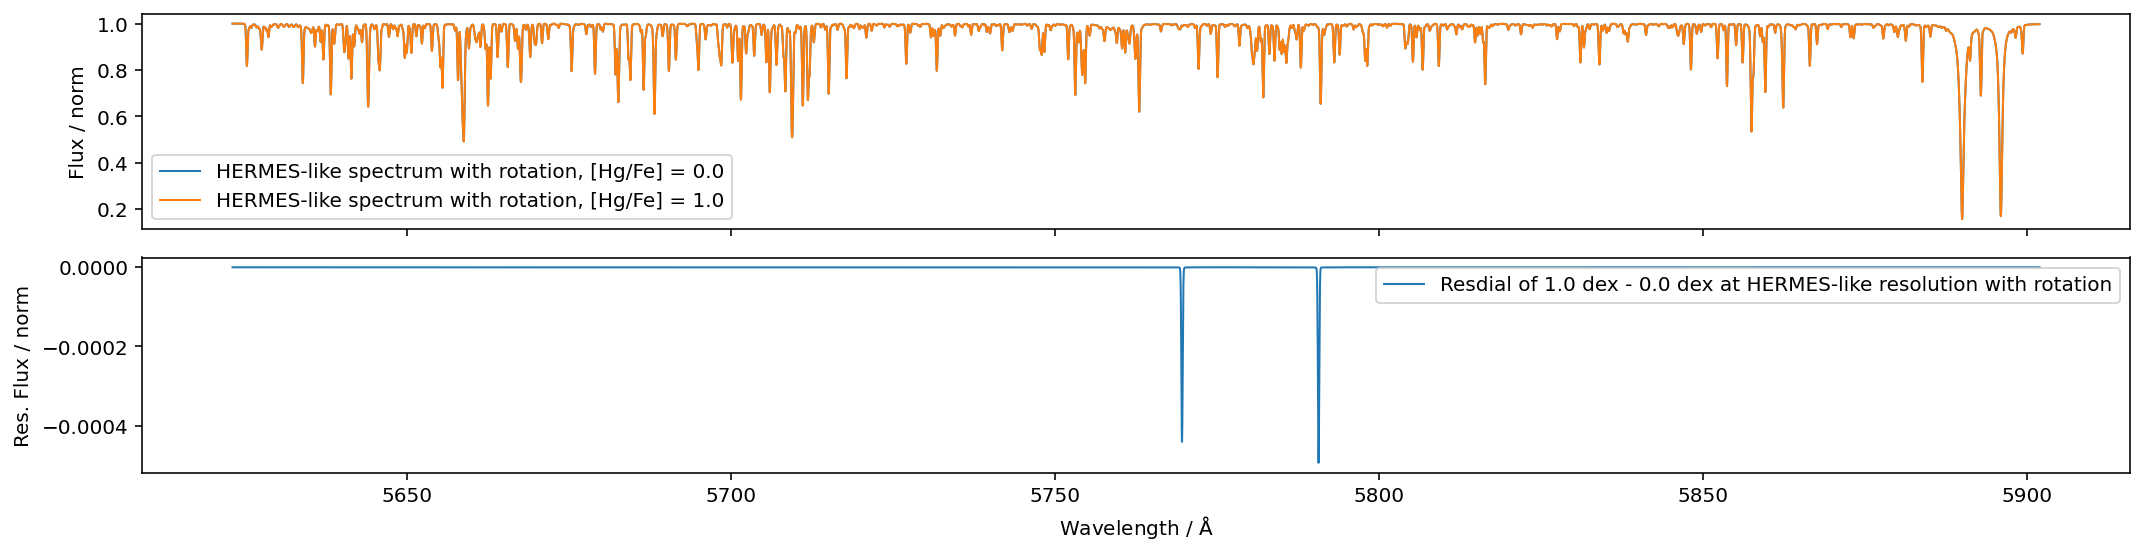

In [92]:
f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    wave_hermes_like_spectrum_hgfe_4,
    smod_hermes_like_spectrum_hgfe_4,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    wave_hermes_like_spectrum_hgfe_5,
    smod_hermes_like_spectrum_hgfe_5,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    wave_hermes_like_spectrum_hgfe_4,
    smod_hermes_like_spectrum_hgfe_5-
    smod_hermes_like_spectrum_hgfe_4,
    label = r'Resdial of 1.0 dex - 0.0 dex at HERMES-like resolution with rotation',lw=1
)
ax.legend()

plt.tight_layout()
plt.savefig('impact_hg_fe_change_of_1dex_for_sun_ccd2.pdf',dpi=200,bbox_inches='tight')

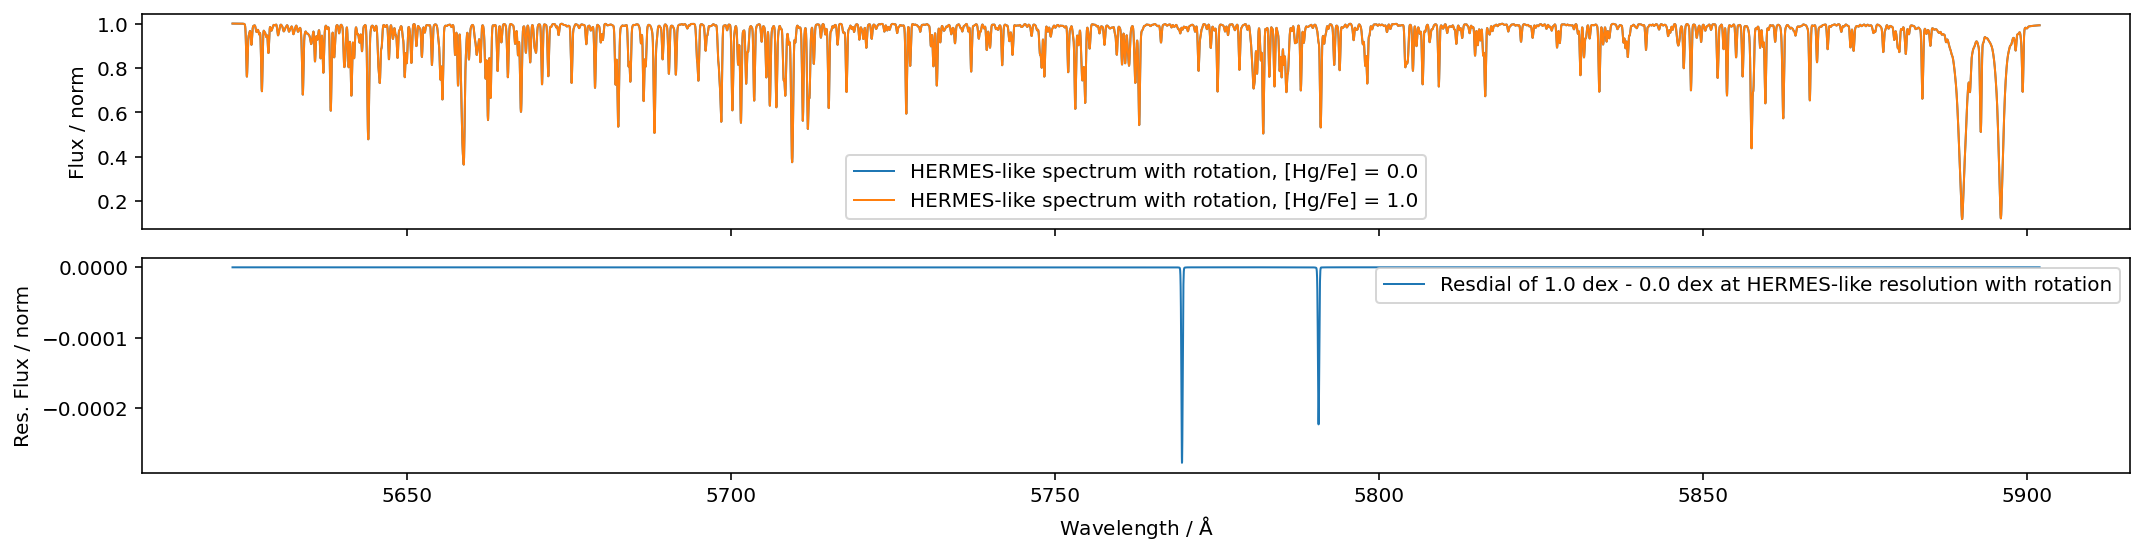

In [93]:
f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    wave_hermes_like_spectrum_hgfe_2,
    smod_hermes_like_spectrum_hgfe_2,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    wave_hermes_like_spectrum_hgfe_3,
    smod_hermes_like_spectrum_hgfe_3,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    wave_hermes_like_spectrum_hgfe_2,
    smod_hermes_like_spectrum_hgfe_3-
    smod_hermes_like_spectrum_hgfe_2,
    label = r'Resdial of 1.0 dex - 0.0 dex at HERMES-like resolution with rotation',lw=1
)
ax.legend()

plt.tight_layout()
plt.savefig('impact_hg_fe_change_of_1dex_for_subgiant_ccd2.pdf',dpi=200,bbox_inches='tight')

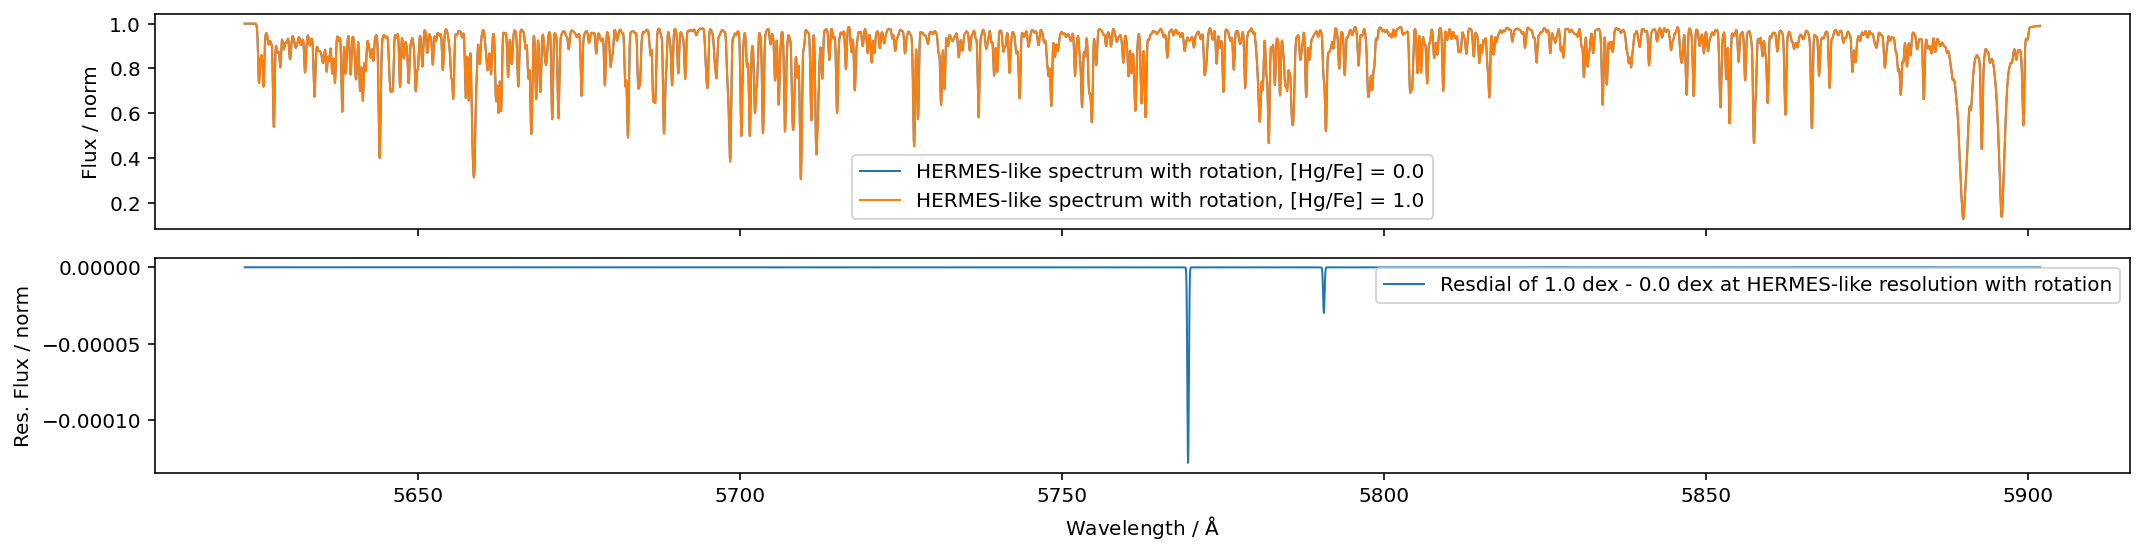

In [94]:
f, gs = plt.subplots(2,1,sharex=True,figsize=(15,4))

ax = gs[0]
ax.set_ylabel('Flux / norm')

ax.plot(
    wave_hermes_like_spectrum_hgfe_0,
    smod_hermes_like_spectrum_hgfe_0,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 0.0',lw=1
)
ax.plot(
    wave_hermes_like_spectrum_hgfe_1,
    smod_hermes_like_spectrum_hgfe_1,
    label = 'HERMES-like spectrum with rotation, [Hg/Fe] = 1.0',lw=1
)
ax.legend()

ax = gs[1]
ax.set_ylabel('Res. Flux / norm')
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')

ax.plot(
    wave_hermes_like_spectrum_hgfe_0,
    smod_hermes_like_spectrum_hgfe_1-
    smod_hermes_like_spectrum_hgfe_0,
    label = r'Resdial of 1.0 dex - 0.0 dex at HERMES-like resolution with rotation',lw=1
)
ax.legend()

plt.tight_layout()
plt.savefig('impact_hg_fe_change_of_1dex_for_171227004801060_ccd2.pdf',dpi=200,bbox_inches='tight')